# Denoising (DAE)

## Introduction

## 0. Imports & variables

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import image_dataset_from_directory
import pandas as pd
from PIL import Image

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
training_folder = './processed_data/photos/'
noisy_folder = './sducesinoisy/'
test_folder = "./OneDrive_2022-09-22/Dataset Livrable 2/Dataset/"

## 1. Création d'images bruitées
### Chargement des images

In [ ]:
def load_images_from_folder(folder_path):
    images = []
    for filename in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append((filename, img))
    return images

original_images = load_images_from_folder(training_folder)

  0%|          | 0/29979 [00:00<?, ?it/s]

### Ajout de bruit et sauvegarde

In [ ]:
def clear_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

def add_gaussian_noise(images, mean=0, sigma=10):
    clear_folder(noisy_folder)
    for filename, img in tqdm(images):
        row, col, ch = img.shape
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        noisy = np.clip(img + gauss, 0, 255).astype(np.uint8)
        noisy_filename = "noisy_" + filename
        cv2.imwrite(noisy_folder + noisy_filename, noisy)

add_gaussian_noise(original_images)

  0%|          | 0/29979 [00:00<?, ?it/s]

## 2. Chargement des données originales et bruitées

In [ ]:
def load_and_normalize_from_directory(directory, batch_size=128, img_size=(152, 152), validation_split=None, subset=None):
    dataset = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode=None,  # Aucun label car nous construisons un autoencoder
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=123,
        validation_split=validation_split,
        subset=subset
    )
    
    dataset = dataset.map(lambda x: x / 255.0, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [ ]:
originals_train = load_and_normalize_from_directory(training_folder, validation_split=0.1, subset='training')
originals_val = load_and_normalize_from_directory(training_folder, validation_split=0.1, subset='validation')
noisies_train = load_and_normalize_from_directory(noisy_folder, validation_split=0.1, subset='training')
noisies_val = load_and_normalize_from_directory(noisy_folder, validation_split=0.1, subset='validation')

Found 29979 files belonging to 1 classes.
Using 26982 files for training.
Found 29979 files belonging to 1 classes.
Using 2997 files for validation.
Found 29979 files belonging to 1 classes.
Using 26982 files for training.
Found 29979 files belonging to 1 classes.
Using 2997 files for validation.


In [ ]:
def combine_datasets(dataset1, dataset2):
    combined_dataset = tf.data.Dataset.zip((dataset1, dataset2))
    return combined_dataset

train_dataset = combine_datasets(noisies_train, originals_train)
val_dataset = combine_datasets(noisies_val, originals_val)

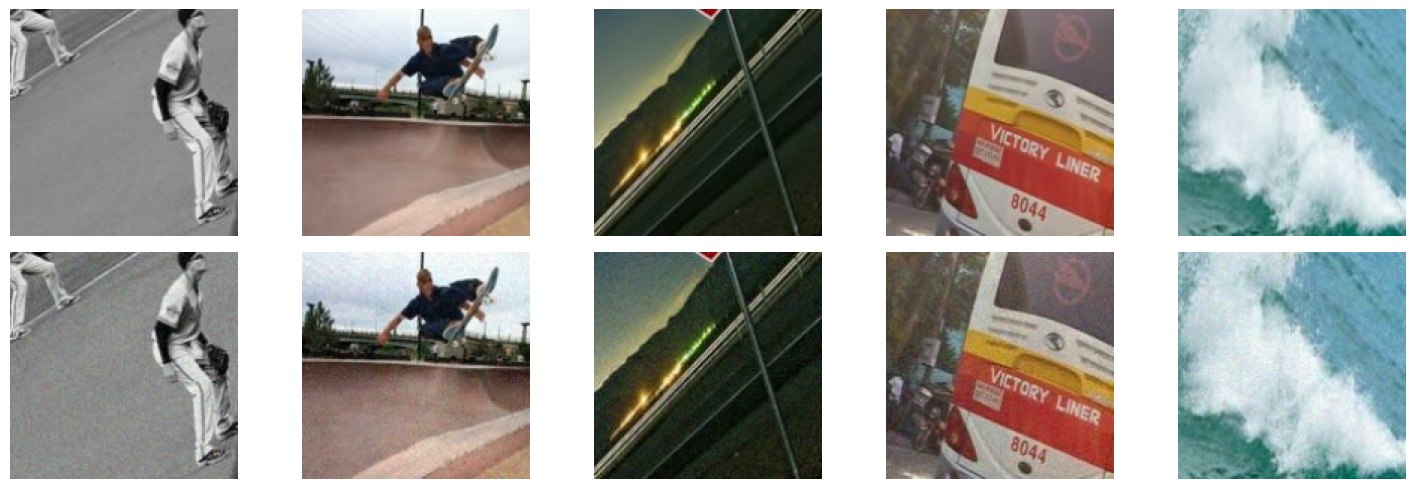

In [ ]:
def display_pairs(train_dataset, num_samples=5):
    # Prendre les num_samples premiers batches du dataset
    samples = list(train_dataset.take(num_samples))
    
    # Extraire la première image de chaque batch pour l'affichage
    noisies_samples = [pair[0][0].numpy() for pair in samples]
    originals_samples = [pair[1][0].numpy() for pair in samples]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[0, i].imshow(originals_samples[i])
        axes[1, i].imshow(noisies_samples[i])
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

display_pairs(train_dataset)

## 3. Création du modèle

In [ ]:
dae = None
with tf.device('/GPU:0'):
    input_shape = (152, 152, 3)

    encoder = Sequential()
    encoder.add(Input(shape=input_shape))
    #encoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    #encoder.add(MaxPooling2D((2, 2), padding='same'))  
    encoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))  
    encoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))   
    
    decoder = Sequential()
    #decoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    #decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  

    dae = Sequential([encoder, decoder])
    dae.compile(optimizer='adam', loss='binary_crossentropy')
    dae.build((None, 152, 152, 3))
    encoder.summary()
    decoder.summary()
    dae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 152, 152, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 76, 76, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 128)      0         
 2D)                                                             
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
______________________________

## 4. Entraînement du modèle

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/dae/" + date
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
#tensorboard --logdir logs/fit/dae --bind_all

model_checkpoint_directory = f"weights/dae/{date}/"
os.makedirs(model_checkpoint_directory, exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_checkpoint_directory}{{epoch:02d}}-{{val_loss:.4f}}.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=False)

with tf.device('/GPU:0'):
    dae.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[tensorboard_callback, model_checkpoint_callback])

In [ ]:
dae.load_weights("./weights/dae/20231009-153246/18-0.5147.h5")

## 5. Evaluation du modèle
### 5.1. Evaluation sur le jeu de test

In [ ]:
def evaluate_model(model, test_dataset):
    loss = model.evaluate(test_dataset)
    print(f"Model Loss: {loss}")
evaluate_model(dae, val_dataset)

In [ ]:
def display_original_daeoutput(originals, reconstructions):
    """Affiche les images originales et les reconstructions côte à côte."""
    n = len(originals)
    
    plt.figure(figsize=(20, 10))
    
    for i in range(n):
        # Afficher l'image originale
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis("off")
        
        # Afficher la reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstruction")
        plt.axis("off")
    
    plt.show()

In [ ]:
for noisy_images, original_images in val_dataset.take(1):  
    noisy_images_np = noisy_images.numpy()
    original_images_np = original_images.numpy()
    reconstructions = dae.predict(noisy_images)

display_original_daeoutput(noisy_images_np[:5], reconstructions[:5])
display_original_daeoutput(original_images_np[:5], reconstructions[:5])

### 5.2. Evaluation sur les données réelles
#### Chargement des données

In [ ]:
def load_data_into_dataframe(path):
    filenames = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    df = pd.DataFrame({'filename': filenames})
    return df

df = load_data_into_dataframe(test_folder)

#### Analyse des données réelles
**Taille des images**

In [ ]:
def plot_image_sizes(df):
    sizes = [Image.open(f).size for f in df['filename']]
    widths, heights = zip(*sizes)
    
    plt.scatter(widths, heights)
    plt.xlabel('Largeur')
    plt.ylabel('Hauteur')
    plt.title('Tailles des images')
    plt.show()

plot_image_sizes(df)

**Types de couleurs**

In [ ]:
def plot_color_modes(df):
    color_modes = [Image.open(f).mode for f in df['filename']]
    mode_counts = pd.Series(color_modes).value_counts()

    mode_counts.plot(kind='bar')
    plt.title('Color Modes')
    plt.ylabel('Number of Images')
    plt.show()

plot_color_modes(df)

**Chargement des données réelles et pré-processing**

In [ ]:
test_dataset = load_and_normalize_from_directory('./OneDrive_2022-09-22/Dataset Livrable 2/Dataset/')

**Comparaison des images originales et des sorties du DAE**

In [ ]:
# Extraire un batch d'images du test_dataset
for images in test_dataset.take(1):  # Prendre un seul batch
    originals = images.numpy()  # Convertir les tensors en numpy arrays
    reconstructions = dae.predict(images)  # Obtenir les reconstructions du DAE

# Afficher quelques images originales et leurs reconstructions
display_original_daeoutput(originals[:5], reconstructions[:5])  # Afficher les 10 premières images et reconstructions
